In [104]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gzip as gz
import matplotlib.pyplot as plt

In [105]:
tf.__version__

'2.0.0-alpha0'

## Basic TensorFlow usage

In [106]:
a = tf.constant([1, 2])
b = tf.constant([3, 4])
print(a + b)

tf.Tensor([4 6], shape=(2,), dtype=int32)


In [107]:
# convinience function to read EMNIST data into numpy array
def read_mnist(images_path, labels_path):
    with gz.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gz.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28)
        features = features.astype(float)
        flip = features[:,:, ::-1,...]       # note that images are flipped
        features = np.rot90(flip, 1, (1,2))  # and rotated 90deg
        
    return features, labels

## Load Data
Test and training data and labels need to be read from the binary files and converted into a form for easy use. Luckily, this data is small enough to fit in memory.
This data set has some pecularities, like images are flipped and rotated 90%. This needs to be accounts for as well.

In [108]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('data/emnist-bymerge-train-images-idx3-ubyte.gz', 'data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('data/emnist-bymerge-test-images-idx3-ubyte.gz', 'data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [109]:
# Lets read the labels so that directories can be named appropriately
def map_labels(label_mappings="data/emnist-bymerge-mapping.txt"):
    labels_dict = {}
    with open(label_mappings, 'rb') as f:
        # each row of the file has the label first and ascii code next
        for line in f:
            items = line.split()
            # note that data is in bytes, so need to convert
            labels_dict.update({int(items[0]): chr(int(items[1]))})
    return labels_dict

# convenience function to display a grid of random images
def display_images(features, labels, mapping):
    # Now, lets try and generate some sample images to see what the data looks like
    fig=plt.figure(figsize=(9, 9))  # show 8in X 8in image
    columns = 4  # 4 images per row
    rows = 5  # lay out images on 5 rows
    for i in range(1, columns*rows +1):
        img_id = np.random.randint(0, features.shape[0])  # max number of images, from prev section
        fig.add_subplot(rows, columns, i)
        img_data = features[img_id].squeeze()  #,:,:]
        plt.title('Label: %d Char: %s' % ( labels[img_id], mapping[labels[img_id]]))
        plt.imshow(img_data, cmap='gray')
    plt.subplots_adjust(hspace=0.5)
    plt.show()


## Visualize Data
It is always useful to plot a few samples of the data, especially for visual applications, to build intuition and ensure things are as expected.

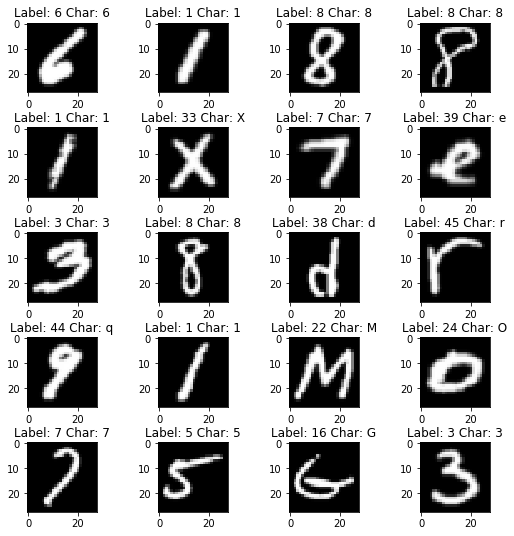

In [110]:
labels = map_labels()
display_images(train['features'], train['labels'], labels)

## Our First Model
Keras makes it really easy to specify model architectures at a high level. In TensorFlow 2.0, further simplfications have been made, so that the code is really clean and simple to follow. In the chapter, the model architecture was specified to have 256 units in first hidden layer, 128 in the second one. The hidden layers had ReLU as the activation function and the output layer had softmax.

In [111]:
model = tf.keras.Sequential(name='First FC DL Model')
# flatten from a 28px X 28px into 784 inputs.
model.add(layers.Flatten(input_shape=(28, 28)))
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(256, activation='relu'))
# Add another:
model.add(layers.Dense(128, activation='relu'))
# Add a softmax layer with 47 output units:
model.add(layers.Dense(47, activation='softmax'))



In [112]:
# useful to check, especially for complex models
model.summary()

Model: "First FC DL Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 47)                6063      
Total params: 239,919
Trainable params: 239,919
Non-trainable params: 0
_________________________________________________________________


### SideBar: Example of losses


In [10]:
# Define the values for binary classification. Each element is a prediction
actual = [0., 0., 1., 1.]
predicted = [0.95, 0.88, 1., 0.]

# different loss definitions
mae = tf.keras.losses.MeanAbsoluteError()
mae_loss = mae(actual, predicted)

mse = tf.keras.losses.MeanSquaredError()
mse_loss = mse(actual, predicted)

print('MAE Loss: ', mae_loss.numpy())  # Loss: 0.7075
print('MSE Loss: ', mse_loss.numpy())  # Loss: 0.6692

MAE Loss:  0.7075
MSE Loss:  0.669225


In [82]:
# Categorical cross entropy loss
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]])
print('Categorical Cross-entropy Loss: ', loss.numpy())  # Loss: 0.3239

Categorical Cross-entropy Loss:  0.32396814


# Compile Model

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
# Simple straightforward training
one_hot_labels = tf.one_hot(train['labels'], 47)
history = model.fit(train['features'], one_hot_labels, epochs=10, batch_size=128)

Epoch 1/10
697932/697932 [==============================] - 23s 32us/sample - loss: 1.3458 - accuracy: 0.6890
Epoch 2/10
697932/697932 [==============================] - 22s 31us/sample - loss: 0.5537 - accuracy: 0.8208
Epoch 3/10
697932/697932 [==============================] - 21s 30us/sample - loss: 0.5070 - accuracy: 0.8350
Epoch 4/10
697932/697932 [==============================] - 19s 27us/sample - loss: 0.4878 - accuracy: 0.8413
Epoch 5/10
697932/697932 [==============================] - 18s 26us/sample - loss: 0.4771 - accuracy: 0.8443
Epoch 6/10
697932/697932 [==============================] - 23s 33us/sample - loss: 0.4712 - accuracy: 0.8461
Epoch 7/10
697932/697932 [==============================] - 20s 29us/sample - loss: 0.4647 - accuracy: 0.8487
Epoch 8/10
697932/697932 [==============================] - 19s 27us/sample - loss: 0.4605 - accuracy: 0.8492
Epoch 9/10
697932/697932 [==============================] - 20s 28us/sample - loss: 0.4560 - accuracy: 0.8508
Epoch 10/1

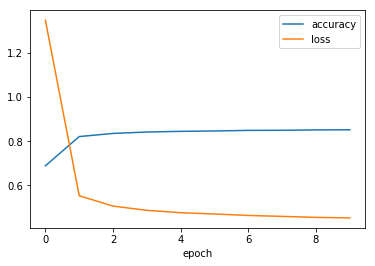

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.xlabel('epoch')
plt.show()

In [18]:
# and evaluation against the test set
one_hot_test = tf.one_hot(test['labels'], 47)
model.evaluate(test['features'], one_hot_test)

116323/116323 [==============================] - 4s 36us/sample - loss: 0.5045 - accuracy: 0.8415


[0.5045455576862516, 0.8414845]

## Confusion Matrix

In [23]:
from sklearn.metrics import classification_report, confusion_matrix  # sklearn has pre-built modules

predictions = model.predict_on_batch(test['features'])  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = confusion_matrix(test['labels'], y_pred)
print(confusion)

Confusion Matrix
[[4927    0    1 ...    0    0    2]
 [   0 5583   17 ...    0    8   16]
 [   0    1 5570 ...    3    1    4]
 ...
 [   0    2    6 ...   73    0    7]
 [   0    5    0 ...    0 2116   39]
 [   1    7    6 ...    0    4 2684]]


### Pretty plotting the confusion matrix

In [ ]:
# convenience function to enable reuse
def plot_confusion_matrix(confusion):
    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(keras.utils.normalize(confusion), cmap="YlGn")

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.75)
    cbar.ax.set_ylabel("Percentage of Samples", rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(47))
    ax.set_yticks(np.arange(47))
    # ... and label them with the respective list entries
    ax.set_xticklabels(list(labels.values()))  # NOTE: The axis labels are hard coded here
    ax.set_yticklabels(list(labels.values()))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(47+1)-.5, minor=True)
    ax.set_yticks(np.arange(47+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=2)

    fig.tight_layout()

    plt.show()
    
# Lets plot the confusion matrix now
plot_confusion_matrix(confusion)

# Normalization of inputs

In [79]:
norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

In [81]:
# Training with normalization of inputs
model.fit(norm_train_features, one_hot_labels, epochs=10, batch_size=128)  # includes a step of data normalization

Epoch 1/10
697932/697932 [==============================] - 28s 41us/sample - loss: 0.5784 - accuracy: 0.8160
Epoch 2/10
697932/697932 [==============================] - 28s 40us/sample - loss: 0.3717 - accuracy: 0.8694
Epoch 3/10
697932/697932 [==============================] - 23s 33us/sample - loss: 0.3458 - accuracy: 0.8762
Epoch 4/10
697932/697932 [==============================] - 19s 27us/sample - loss: 0.3293 - accuracy: 0.8805
Epoch 5/10
697932/697932 [==============================] - 19s 28us/sample - loss: 0.3180 - accuracy: 0.8840
Epoch 6/10
697932/697932 [==============================] - 16s 22us/sample - loss: 0.3099 - accuracy: 0.8862
Epoch 7/10
697932/697932 [==============================] - 16s 23us/sample - loss: 0.3033 - accuracy: 0.8884
Epoch 8/10
697932/697932 [==============================] - 17s 24us/sample - loss: 0.2972 - accuracy: 0.8896
Epoch 9/10
697932/697932 [==============================] - 16s 23us/sample - loss: 0.2919 - accuracy: 0.8912
Epoch 10/1

In [83]:
# and evaluation
model.evaluate(norm_test_features, tf.one_hot(test['labels'], 47))

116323/116323 [==============================] - 5s 45us/sample - loss: 0.3576 - accuracy: 0.8759


[0.35755516977440993, 0.8758543]

In [84]:
predictions = model.predict_on_batch(test['features'])  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = confusion_matrix(test['labels'], y_pred)
print(confusion)

Confusion Matrix
[[1055    0   41 ...    0    1   41]
 [   0  451    5 ...    0    7   44]
 [   0    2 3757 ...    0    0    5]
 ...
 [   0    0    6 ...   30    0   91]
 [   0    0    3 ...    0  623  404]
 [   0    0   10 ...    0    0 2650]]


In [ ]:
plot_confusion_matrix(confusion)

In [88]:
# model was trained with data normalization and test set was not normalized
# and evaluation
model.evaluate(test['features'], tf.one_hot(test['labels'], 47))

116323/116323 [==============================] - 4s 35us/sample - loss: 762.8006 - accuracy: 0.6203


[762.8005877422722, 0.6202986]

## Precision and recall metrics


In [97]:
from sklearn.metrics import classification_report

pred = model.predict(norm_test_features, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(test['labels'], predicted)
print(report)

116323/116323 [==============================] - 1s 13us/sample
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      5745
           1       0.67      0.87      0.76      6400
           2       0.94      0.95      0.95      5765
           3       0.98      0.99      0.98      5827
           4       0.95      0.96      0.95      5498
           5       0.92      0.90      0.91      5326
           6       0.96      0.97      0.96      5787
           7       0.97      0.98      0.98      5873
           8       0.95      0.97      0.96      5655
           9       0.93      0.97      0.95      5651
          10       0.93      0.88      0.90      1058
          11       0.88      0.85      0.87       652
          12       0.95      0.93      0.94      2156
          13       0.81      0.86      0.84       735
          14       0.93      0.91      0.92       860
          15       0.81      0.73      0.77      1524
          16     

## Saving and reloading a model

In [103]:
from keras.models import load_model

# lets save the last trained model using data normalization
model.save("emnist_fc_model.h5")

ModuleNotFoundError: No module named 'keras'